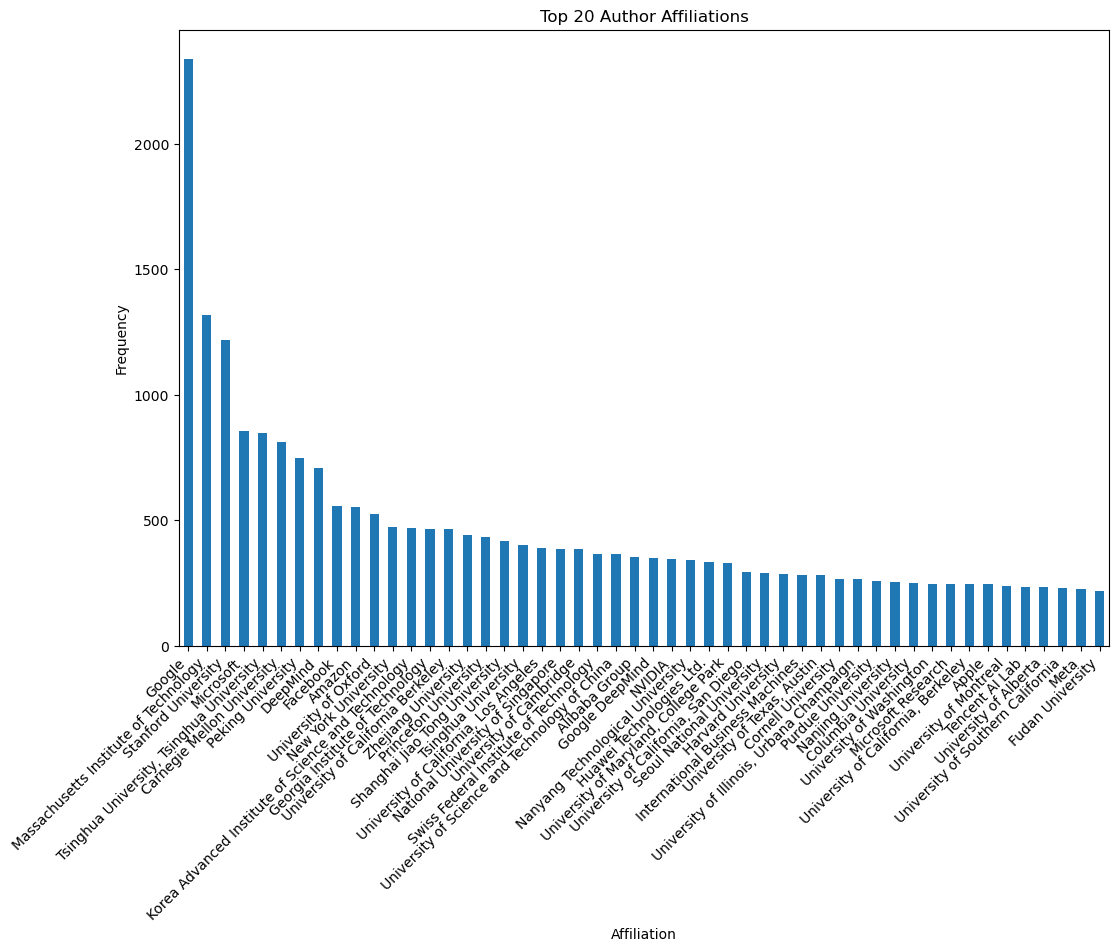

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the author dataset
authors_df = pd.read_csv('./dataset/gathered_author.csv')

# Count the frequency of each affiliation and get top 20
top_affiliations = authors_df['author_affiliation'].value_counts().head(50)

# Plotting the distribution of top 20 author affiliations
plt.figure(figsize=(12, 8))
top_affiliations.plot(kind='bar')
plt.title('Top 20 Author Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [2]:
import os

# undersample google
def make_top_k_dataset(k, seed=0, feature=300):
    
    authors_df = pd.read_csv(f'./dataset/gathered_author.csv')
    papers_df = pd.read_csv(f'./dataset/gathered_paper_filtered_{feature}.csv')

    print('Author Before processing : ',len(authors_df))
    
    # Filter authors by affiliation type 0 and get top 20 affiliations
    top_20_affiliations_type_0 = authors_df[authors_df['author_affiliation_type'] == 0]['author_affiliation'].value_counts().head(k).index

    # Filter authors by affiliation type 1 and get top 20 affiliations
    top_20_affiliations_type_1 = authors_df[authors_df['author_affiliation_type'] == 1]['author_affiliation'].value_counts().head(k).index

    # Combine the top 20 affiliations for both types
    combined_top_affiliations = top_20_affiliations_type_0.union(top_20_affiliations_type_1)

    # Filter the authors to only include those whose affiliation is in the combined top 20 for both types
    filtered_authors_top_k_df = authors_df[authors_df['author_affiliation'].isin(combined_top_affiliations)]
    
    # Determine the count of the second top affiliation
    affiliation_counts = filtered_authors_top_k_df['author_affiliation'].value_counts()
    second_top_affiliation_count = affiliation_counts.iloc[1]  # Assuming the first is 'Google'

    # If 'Google' is the top affiliation, randomly downsample it to match the second top
    if 'Google' in affiliation_counts.index:
        google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] == 'Google']
        sampled_google_entries = google_entries.sample(n=second_top_affiliation_count, random_state=seed)
        non_google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] != 'Google']
        filtered_authors_top_k_df = pd.concat([sampled_google_entries, non_google_entries])

    print('Author After processing:', len(filtered_authors_top_k_df))

    
    # Load the paper dataset
    print("Paper Before processing : ", len(papers_df))

    # Get the unique paper IDs from the filtered authors dataset
    unique_paper_ids = filtered_authors_top_k_df['paper_id'].unique()

    # Filter the papers to only include those whose paper IDs are in the filtered authors dataset
    filtered_papers_df = papers_df[papers_df['paper_id'].isin(unique_paper_ids)]
    
    # Modify 'paper_abstract_filtered_*' columns
    filtered_columns = [col for col in filtered_papers_df.columns if col.startswith('paper_abstract_filtered_')]
    for col in filtered_columns:
        filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


    # Display the first few rows of the filtered papers dataframe
    # filtered_papers_df.head()
    print("Paper After processing : ", len(filtered_papers_df))
    
    
    vis_filtered_authors = filtered_authors_top_k_df['author_affiliation'].value_counts()
    plt.figure(figsize=(12, 8))
    vis_filtered_authors.plot(kind='bar')
    plt.title('Top 20 Author Affiliations')
    plt.xlabel('Affiliation')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    k = k*2
    author_dir = f"./dataset/processed/{k}_label/"
    paper_dir = f"./dataset/processed/{k}_label/"
    
    if not os.path.exists(author_dir):
        os.makedirs(author_dir)
    if not os.path.exists(paper_dir):
        os.makedirs(paper_dir)
    filtered_authors_top_k_df.to_csv(author_dir+f"authors.csv")
    filtered_papers_df.to_csv(paper_dir+f"papers_{feature}.csv")
    
    

이제 top_20_df에 없는 paper_id를 가지고 있는 paper들을 gathered_paper.csv에서 지울 예정.

처리된 author, paper dataframe을 csv로 바꿔줄 예정.

Author Before processing :  54819
Author After processing: 8936
Paper Before processing :  12873


/tmp/ipykernel_1349838/2410538028.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


Paper After processing :  4323


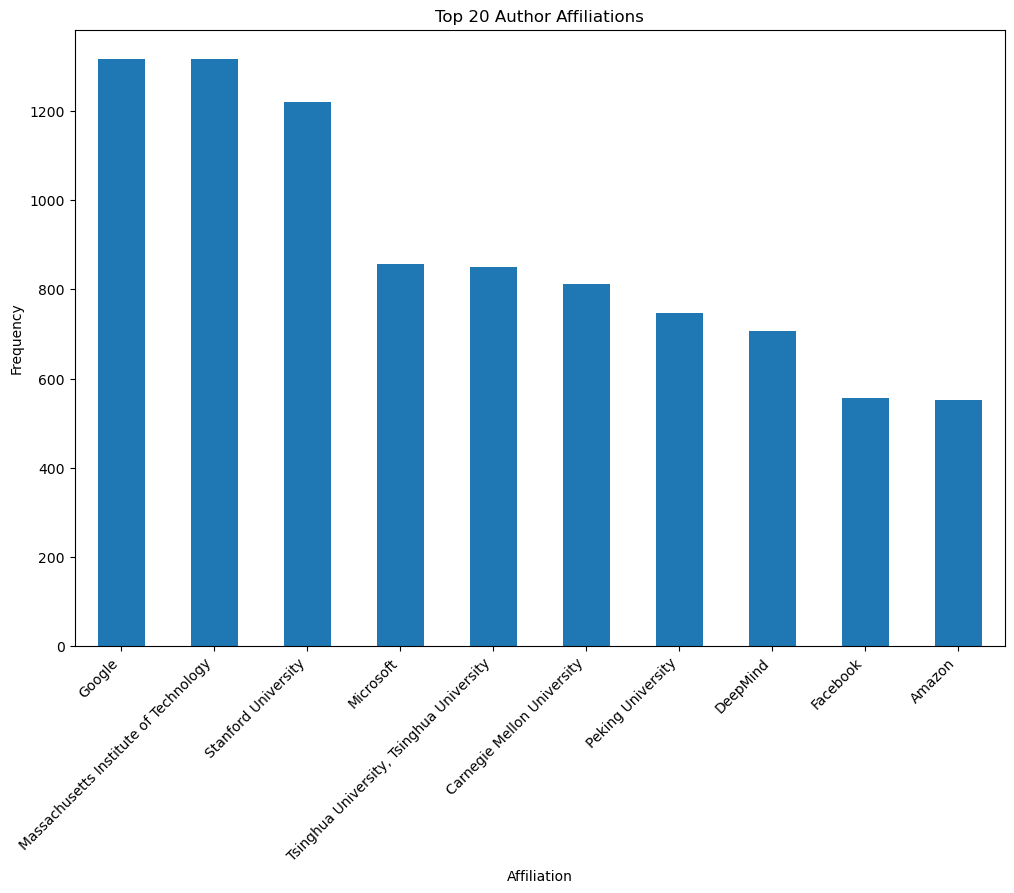

Author Before processing :  54819
Author After processing: 8936
Paper Before processing :  12873


/tmp/ipykernel_1349838/2410538028.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


Paper After processing :  4323


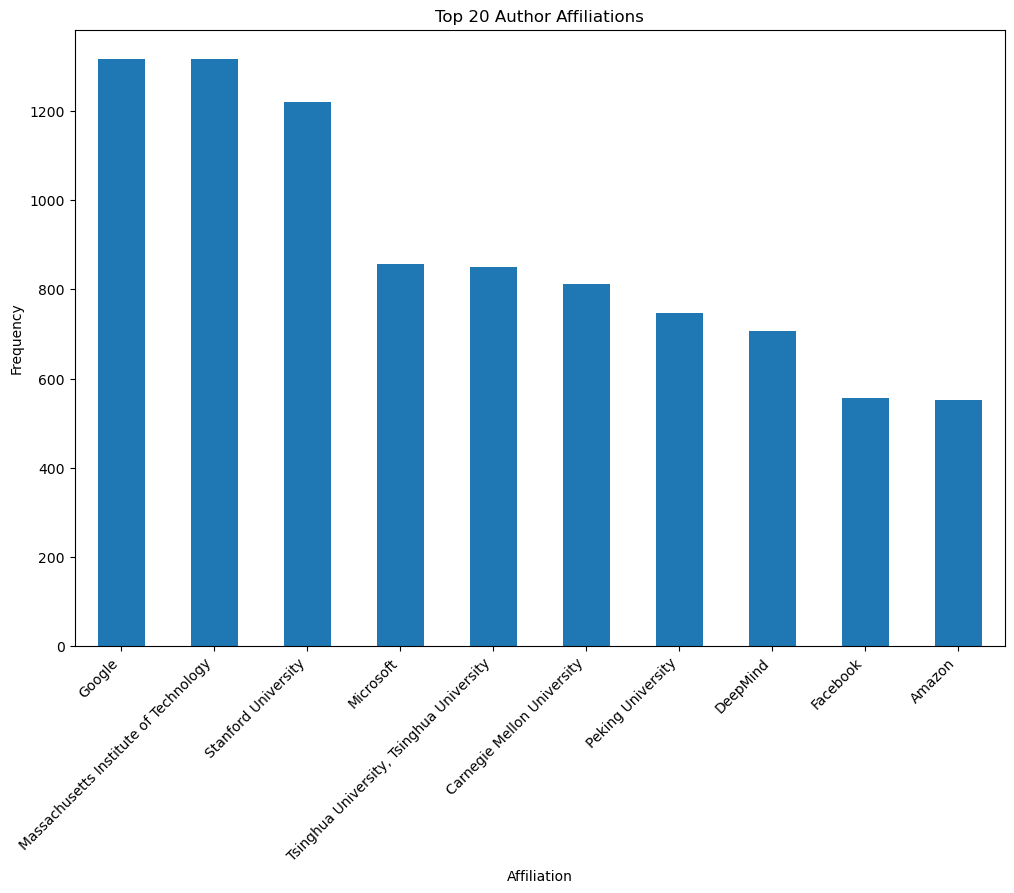

Author Before processing :  54819
Author After processing: 8936
Paper Before processing :  12873


/tmp/ipykernel_1349838/2410538028.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


Paper After processing :  4323


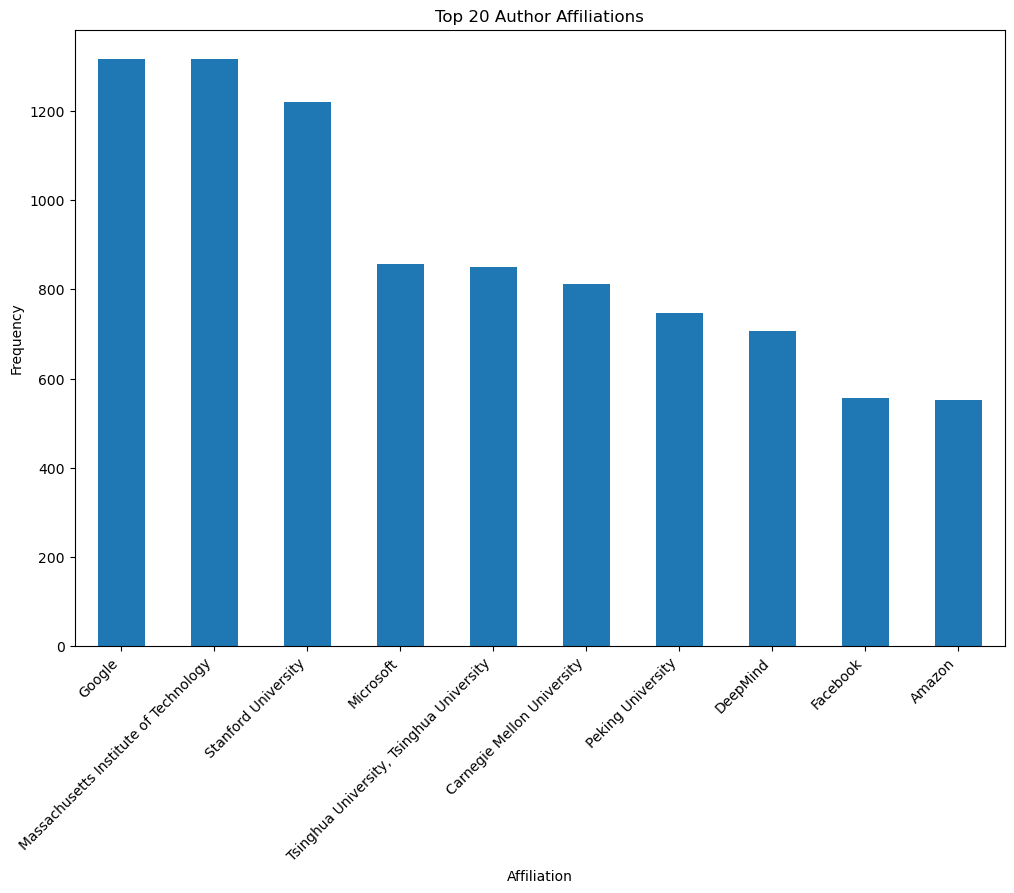

In [3]:
k=5
seed=0
feature_list=[300, 500, 1000]
for feature in feature_list:
    make_top_k_dataset(k, seed, feature)

In [ ]:
import os

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# undersample google
def make_top_k_dataset(k, seed=0, feature=300):
    
    authors_df = pd.read_csv(f'./dataset/gathered_author.csv')
    papers_df = pd.read_csv(f'./dataset/gathered_paper_filtered_{feature}.csv')

    print('Author Before processing : ',len(authors_df))
    
    # Filter authors by affiliation type 0 and get top 20 affiliations
    top_20_affiliations_type_0 = authors_df[authors_df['author_affiliation_type'] == 0]['author_affiliation'].value_counts().head(k).index

    # Filter authors by affiliation type 1 and get top 20 affiliations
    top_20_affiliations_type_1 = authors_df[authors_df['author_affiliation_type'] == 1]['author_affiliation'].value_counts().head(k).index

    # Combine the top 20 affiliations for both types
    combined_top_affiliations = top_20_affiliations_type_0.union(top_20_affiliations_type_1)

    # Filter the authors to only include those whose affiliation is in the combined top 20 for both types
    filtered_authors_top_k_df = authors_df[authors_df['author_affiliation'].isin(combined_top_affiliations)]
    
    # Determine the count of the second top affiliation
    affiliation_counts = filtered_authors_top_k_df['author_affiliation'].value_counts()
    second_top_affiliation_count = affiliation_counts.iloc[1]  # Assuming the first is 'Google'

    # If 'Google' is the top affiliation, randomly downsample it to match the second top
    if 'Google' in affiliation_counts.index:
        google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] == 'Google']
        sampled_google_entries = google_entries.sample(n=second_top_affiliation_count, random_state=seed)
        non_google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] != 'Google']
        filtered_authors_top_k_df = pd.concat([sampled_google_entries, non_google_entries])

    print('Author After processing:', len(filtered_authors_top_k_df))

    
    # Load the paper dataset
    print("Paper Before processing : ", len(papers_df))

    # Get the unique paper IDs from the filtered authors dataset
    unique_paper_ids = filtered_authors_top_k_df['paper_id'].unique()

    # Filter the papers to only include those whose paper IDs are in the filtered authors dataset
    filtered_papers_df = papers_df[papers_df['paper_id'].isin(unique_paper_ids)]
    
    # Modify 'paper_abstract_filtered_*' columns
    filtered_columns = [col for col in filtered_papers_df.columns if col.startswith('paper_abstract_filtered_')]
    for col in filtered_columns:
        filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


    # Display the first few rows of the filtered papers dataframe
    # filtered_papers_df.head()
    print("Paper After processing : ", len(filtered_papers_df))
    
    
    vis_filtered_authors = filtered_authors_top_k_df['author_affiliation'].value_counts()
    plt.figure(figsize=(12, 8))
    vis_filtered_authors.plot(kind='bar')
    plt.title('Top 20 Author Affiliations')
    plt.xlabel('Affiliation')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    k = k*2
    author_dir = f"./dataset/processed/{k}_label/"
    paper_dir = f"./dataset/processed/{k}_label/"
    
    if not os.path.exists(author_dir):
        os.makedirs(author_dir)
    if not os.path.exists(paper_dir):
        os.makedirs(paper_dir)
    filtered_authors_top_k_df.to_csv(author_dir+f"authors.csv")
    filtered_papers_df.to_csv(paper_dir+f"papers_{feature}.csv")
    
    

## Create author-paper joined dataset

In [7]:
import pandas as pd

feature_list = [300, 500, 1000]
# Load the datasets
for feature in feature_list:
    authors_df = pd.read_csv('./dataset/undersample/10_label/authors.csv')
    papers_df = pd.read_csv(f'./dataset/undersample/10_label/papers_{feature}.csv')
    
    # Drop columns starting with "Unnamed" and the index column from papers_df
    papers_df = papers_df.loc[:, ~papers_df.columns.str.startswith('Unnamed')]
    papers_df = papers_df.drop(columns=['index'], errors='ignore')  # errors='ignore' allows it to fail gracefully if 'index' column doesn't exist


    # Merge the datasets on 'paper_id'
    merged_df = pd.merge(authors_df, papers_df, on='paper_id', how='left')

    # Optionally, you can save the merged dataset to a new CSV file
    merged_df.to_csv(f'./dataset/merged/data_{feature}.csv', index=False)

In [8]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

# Load the dataset
data_path = "/home/khm/data_mining_2/final_project/dataset/merged/data_300.csv"
df = pd.read_csv(data_path)

# Define features and target
feature_columns = [col for col in df.columns if col.startswith("paper_abstract_filtered")]
X = df[feature_columns]
y = df['author_affiliation']

# Initialize a classifier for feature selection
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFECV
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(5), scoring=make_scorer(accuracy_score))

# Fit RFECV
rfecv.fit(X, y)

# Print the optimal number of features
print('Optimal number of features:', rfecv.n_features_)

# Get the mask of selected features
selected_features = X.columns[rfecv.support_]

# Print selected features
print('Selected features:', selected_features.tolist())


Optimal number of features: 292
Selected features: ['paper_abstract_filtered_12', 'paper_abstract_filtered_7', 'paper_abstract_filtered_11', 'paper_abstract_filtered_14', 'paper_abstract_filtered_16', 'paper_abstract_filtered_52', 'paper_abstract_filtered_15', 'paper_abstract_filtered_13', 'paper_abstract_filtered_36', 'paper_abstract_filtered_19', 'paper_abstract_filtered_43', 'paper_abstract_filtered_2239', 'paper_abstract_filtered_42', 'paper_abstract_filtered_166', 'paper_abstract_filtered_30', 'paper_abstract_filtered_25', 'paper_abstract_filtered_1421', 'paper_abstract_filtered_32', 'paper_abstract_filtered_414', 'paper_abstract_filtered_64', 'paper_abstract_filtered_41', 'paper_abstract_filtered_61', 'paper_abstract_filtered_31', 'paper_abstract_filtered_84', 'paper_abstract_filtered_3092', 'paper_abstract_filtered_96', 'paper_abstract_filtered_28', 'paper_abstract_filtered_1058', 'paper_abstract_filtered_1437', 'paper_abstract_filtered_1629', 'paper_abstract_filtered_311', 'pap

# Paper preprocessing from here!

In [3]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

In [4]:

def map_abstract_token_columns(data):
    data['paper_abstract_tk'] = data['paper_abstract_tk'].apply(lambda x: ast.literal_eval(x))
    abstract_tokens = pd.DataFrame(data['paper_abstract_tk'].tolist())
    top_1000_tokens = abstract_tokens.apply(pd.value_counts).fillna(0).sum(axis=1).sort_values(ascending=False).iloc[:1000]
    filtered_df = pd.DataFrame(np.where(abstract_tokens.isin(top_1000_tokens.keys()), abstract_tokens, int(1)))
    final_df = filtered_df.apply(pd.Series.value_counts, axis=1)[top_1000_tokens.keys()].fillna(0)
    final_df.columns = ['paper_abstract_filtered_' + x for x in list(final_df.columns.astype(int).astype(str))]
    result_df = pd.concat([data, final_df], axis=1)

    return result_df

In [5]:

import pandas as pd
data = pd.read_csv('./dataset/gathered_paper4.csv', encoding_errors='ignore')
df = map_abstract_token_columns(data)


/tmp/ipykernel_1706989/1302877162.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  top_1000_tokens = abstract_tokens.apply(pd.value_counts).fillna(0).sum(axis=1).sort_values(ascending=False).iloc[:1000]


In [6]:
df.head()
df.to_csv('./dataset/gathered_paper_filtered_1000.csv')


In [7]:
import os

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


# undersample google
def make_top_k_dataset(k, seed=0, feature=1000):
    
    authors_df = pd.read_csv(f'./dataset/gathered_author.csv')
    papers_df = pd.read_csv(f'./dataset/gathered_paper_filtered_{feature}.csv')

    print('Author Before processing : ',len(authors_df))
    
    # Filter authors by affiliation type 0 and get top 20 affiliations
    top_20_affiliations_type_0 = authors_df[authors_df['author_affiliation_type'] == 0]['author_affiliation'].value_counts().head(k).index

    # Filter authors by affiliation type 1 and get top 20 affiliations
    top_20_affiliations_type_1 = authors_df[authors_df['author_affiliation_type'] == 1]['author_affiliation'].value_counts().head(k).index

    # Combine the top 20 affiliations for both types
    combined_top_affiliations = top_20_affiliations_type_0.union(top_20_affiliations_type_1)

    # Filter the authors to only include those whose affiliation is in the combined top 20 for both types
    filtered_authors_top_k_df = authors_df[authors_df['author_affiliation'].isin(combined_top_affiliations)]
    
    # Determine the count of the second top affiliation
    affiliation_counts = filtered_authors_top_k_df['author_affiliation'].value_counts()
    second_top_affiliation_count = affiliation_counts.iloc[1]  # Assuming the first is 'Google'

    # If 'Google' is the top affiliation, randomly downsample it to match the second top
    if 'Google' in affiliation_counts.index:
        google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] == 'Google']
        sampled_google_entries = google_entries.sample(n=second_top_affiliation_count, random_state=seed)
        non_google_entries = filtered_authors_top_k_df[filtered_authors_top_k_df['author_affiliation'] != 'Google']
        filtered_authors_top_k_df = pd.concat([sampled_google_entries, non_google_entries])

    print('Author After processing:', len(filtered_authors_top_k_df))

    
    # Load the paper dataset
    print("Paper Before processing : ", len(papers_df))

    # Get the unique paper IDs from the filtered authors dataset
    unique_paper_ids = filtered_authors_top_k_df['paper_id'].unique()

    # Filter the papers to only include those whose paper IDs are in the filtered authors dataset
    filtered_papers_df = papers_df[papers_df['paper_id'].isin(unique_paper_ids)]
    
    # Modify 'paper_abstract_filtered_*' columns
    filtered_columns = [col for col in filtered_papers_df.columns if col.startswith('paper_abstract_filtered_')]
    for col in filtered_columns:
        filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


    # Display the first few rows of the filtered papers dataframe
    # filtered_papers_df.head()
    print("Paper After processing : ", len(filtered_papers_df))
    
    
    vis_filtered_authors = filtered_authors_top_k_df['author_affiliation'].value_counts()
    plt.figure(figsize=(12, 8))
    vis_filtered_authors.plot(kind='bar')
    plt.title('Top 20 Author Affiliations')
    plt.xlabel('Affiliation')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    k = k*2
    author_dir = f"./dataset/processed/{k}_label/"
    paper_dir = f"./dataset/processed/{k}_label/"
    
    if not os.path.exists(author_dir):
        os.makedirs(author_dir)
    if not os.path.exists(paper_dir):
        os.makedirs(paper_dir)
    filtered_authors_top_k_df.to_csv(author_dir+f"authors.csv")
    filtered_papers_df.to_csv(paper_dir+f"papers_{feature}.csv")
    
    

Author Before processing :  54819
Author After processing: 8936
Paper Before processing :  12873


/tmp/ipykernel_1706989/3739664338.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_papers_df[col] = filtered_papers_df[col].apply(lambda x: 1 if x > 0 else 0)


Paper After processing :  4323


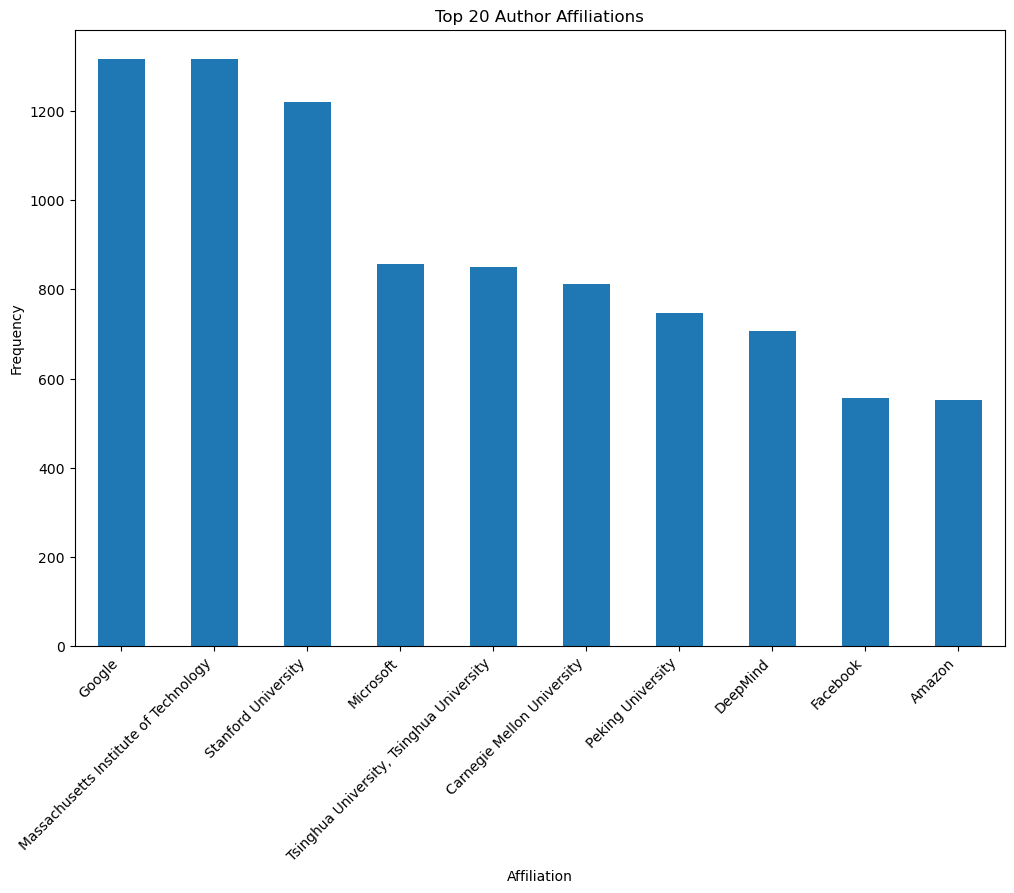

In [8]:
make_top_k_dataset(5, seed=0, feature=1000)

In [9]:
import pandas as pd

feature_list = [1000]
# Load the datasets
for feature in feature_list:
    authors_df = pd.read_csv('./dataset/processed/10_label/authors.csv')
    papers_df = pd.read_csv(f'./dataset/processed/10_label/papers_{feature}.csv')
    
    # Drop columns starting with "Unnamed" and the index column from papers_df
    papers_df = papers_df.loc[:, ~papers_df.columns.str.startswith('Unnamed')]
    papers_df = papers_df.drop(columns=['index'], errors='ignore')  # errors='ignore' allows it to fail gracefully if 'index' column doesn't exist


    # Merge the datasets on 'paper_id'
    merged_df = pd.merge(authors_df, papers_df, on='paper_id', how='left')

    # Optionally, you can save the merged dataset to a new CSV file
    merged_df.to_csv(f'./dataset/merged/data_{feature}.csv', index=False)